#### If you haven't installed Hummingbird, do that first, by uncommenting the line below.


In [1]:
#! python -m pip install hummingbird_ml 

#### Import Hummingbird's convert function

In [2]:
from hummingbird.ml import convert

#### Download and unzip the Year data

In [3]:
import zipfile
import urllib.request as urllib
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip'

filehandle, _ = urllib.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
filename = zip_file_object.namelist()[0]
bytes_data = zip_file_object.open(filename).read()

#### Convert the bytes to pandas and split it up

In [4]:
import pandas as pd
from io import BytesIO
from sklearn.model_selection import train_test_split

year = pd.read_csv(BytesIO(bytes_data), header = None)

#train_size = 463715  # Note: this will extend the training time if we do the full dataset
train_size = 200000
X = year.iloc[:, 1:]
y = year.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=train_size, test_size=51630)

# Store the test data as numpy by pulling the values out of the pandas dataframe
data = X_test.values

In [5]:
# peak at the data if desired
X_test.head()

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
200000,45.09540,-57.29138,20.05392,0.10414,12.00346,-14.31259,2.54547,-3.33986,-3.60175,-8.99414,...,7.15503,-81.48297,34.91722,15.11917,-6.09056,-78.52893,-46.87559,2.89571,64.25949,0.78578
200001,45.11673,-18.39958,-1.61552,-3.67929,-13.24027,-6.84375,-10.33838,-11.12891,16.56924,6.70243,...,8.26246,-138.26547,23.59451,60.99156,4.18891,105.75496,-126.39851,-3.80727,55.00532,-3.42354
200002,46.85191,9.44824,0.31518,-16.85413,15.42389,-15.82587,-21.21385,-10.16067,14.45113,2.22865,...,13.24783,-91.25475,41.12300,55.22389,8.33048,7.57355,17.34516,0.21543,-58.34520,3.92760
200003,45.79644,-36.86230,21.99320,-10.42360,-2.89410,-8.84010,-23.73864,-9.82956,13.08399,0.57577,...,8.13403,-194.21155,55.55883,21.65387,6.41164,-47.18867,-212.14270,-4.67550,-86.99988,-6.12034
200004,40.92442,-43.26026,-18.72100,-11.72495,-19.69395,-10.54229,-9.91945,-14.85633,9.37409,-0.93093,...,17.63167,-203.56276,27.10714,36.90795,0.62431,-40.23377,-83.22141,4.44391,73.15568,3.25023


#### Train the model  (Note, this may take a bit of time for larger values of _num_est_. )

In [6]:
from sklearn.ensemble import RandomForestRegressor
num_est=100

skl_model = RandomForestRegressor(n_estimators=num_est, max_depth=8)
skl_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### scikit-learn (CPU only)

In [7]:
skl_time = %timeit -o skl_model.predict(data)

382 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Convert scikit-learn model to PyTorch

In [8]:
model = convert(skl_model, 'torch')

#### Time PyTorch - CPU

In [9]:
pred_cpu_hb = %timeit -o model.predict(data)

317 ms ± 8.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Switch PyTorch from CPU to GPU

In [10]:
%%capture 
model.to('cuda')

#### Time PyTorch - GPU

In [11]:
pred_gpu_hb = %timeit -o model.predict(data)

12.5 ms ± 88.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Note: Continuing in this notebook requires TVM built with LLVM support. Install instructions [here](https://tvm.apache.org/docs/install/index.html)

#### Convert scikit-learn model to TVM (CPU)

In [12]:
model_tvm = convert(skl_model, 'tvm', data)

#### Time TVM - CPU

In [13]:
pred_cpu_tvm = %timeit -o model_tvm.predict(data)

155 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Convert scikit-learn model to TVM (GPU)

In [14]:
model_tvm = convert(skl_model, 'tvm', data, 'cuda')

#### Time TVM - GPU

In [15]:
pred_gpu_tvm = %timeit -o model_tvm.predict(data)

20.5 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Plot the results

In [16]:
def plot(title, skl_time, pred_cpu_hb, pred_gpu_hb, pred_cpu_tvm, pred_gpu_tvm):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.pyplot import cm

    fig = plt.figure()

    x = ['skl','pyt-cpu','pyt-gpu','tvm-cpu','tvm-gpu']
    height = [skl_time.average,pred_cpu_hb.average,pred_gpu_hb.average,pred_cpu_tvm.average,pred_gpu_tvm.average]
    width = 1.0
    plt.ylabel('time in seconds')
    plt.xlabel(title)

    rects = plt.bar(x, height, width, color=cm.rainbow(np.linspace(0,1,5)))
    def autolabel(rects):

        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%.4f' % (height),
                    ha='center', va='bottom')

    autolabel(rects)
    plt.show()

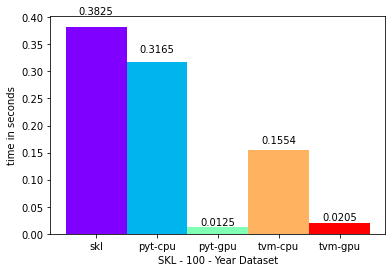

In [17]:
chartname = "SKL - " + str(num_est) + " - Year Dataset"

plot(chartname, skl_time, pred_cpu_hb, pred_gpu_hb, pred_cpu_tvm, pred_gpu_tvm)